<a href="https://colab.research.google.com/github/montjoile/Meta-learning/blob/master/bias_testing.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

#Code for Testing Bias 

\\

This notebook contains experiments to check the presence of bias in the three datasets. I refer as Bias as the intrinsic characteristics of the images in each dataset. The goal is to train a model that can recognize which dataset an image is from. If the model scores more than 33% of accuracy, we can say the datasets are biased, as the model would be able to recognize the inherent characteristics of the datasets. If the performance of the model is no greater than 33% it would mean that the images in the datasets are similar, so we can proceed to design a further meta-learning model. 

My hypothesis is that there exist unique characteristics in each dataset that will make the images differentiable between datasets.

\\

**This notebook contains:**

* Experiment to detect dataset bias


\\

**Notes:**

I used a random state of 42 on the train/test spllit for reproducible results, this will change to completely random on the final testing in the hpc.
I used a very small batch of samples from the original dataset on this notebook. (326 samples from the 3 datasets). The reason was the limitation of Colab environment. The results of the same experiments with the full samples are expected to be similar that the ones obtained here.

\\

**Observations:**

* It is worth to note that the class proportion within the train and test set differ, one sign of dataset shift, but the model perform with very high accuracy on the test set, which is highly imbalanced, suggesting that there is no symtoms of data shift.

* Cross validation is performed to average the results.

\\


The experiment performed here is *Name that dataset!* which can be found  [here](http://citeseerx.ist.psu.edu/viewdoc/download?doi=10.1.1.208.2314&rep=rep1&type=pdf)

### Mount Google drive

In [1]:
# Run this cell to mount your Google Drive.
from google.colab import drive
drive.mount('/content/drive')

Go to this URL in a browser: https://accounts.google.com/o/oauth2/auth?client_id=947318989803-6bn6qk8qdgf4n4g3pfee6491hc0brc4i.apps.googleusercontent.com&redirect_uri=urn%3Aietf%3Awg%3Aoauth%3A2.0%3Aoob&scope=email%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdocs.test%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fdrive.photos.readonly%20https%3A%2F%2Fwww.googleapis.com%2Fauth%2Fpeopleapi.readonly&response_type=code

Enter your authorization code:
··········
Mounted at /content/drive


###Import Libraries

In [2]:
import pandas as pd
import numpy as np
import os
from keras.utils import np_utils
from sklearn.utils import shuffle, class_weight
from PIL import Image
from keras.preprocessing import image
from collections import Counter
import matplotlib.pyplot as plt
from sklearn.model_selection import train_test_split
import keras
from keras.models import Sequential
from keras.layers import Activation, Dense, Dropout, Flatten, Conv2D, MaxPooling2D, BatchNormalization
from keras.preprocessing.image import ImageDataGenerator, array_to_img, img_to_array, load_img
import cv2
import shutil
from keras.callbacks import ModelCheckpoint
from keras import models
from sklearn.model_selection import KFold
from keras import optimizers
from sklearn.metrics import classification_report, precision_recall_fscore_support
import sklearn.metrics as metrics
from imblearn.keras import BalancedBatchGenerator
from sklearn.metrics import roc_auc_score, confusion_matrix, accuracy_score
import pandas as pd
from pathlib import Path
import time
import matplotlib.image as mpimg
import math
import seaborn as sn
from mpl_toolkits.axes_grid1 import make_axes_locatable
import matplotlib as mpl
import itertools
import seaborn as sns

Using TensorFlow backend.
/usr/local/lib/python3.6/dist-packages/sklearn/externals/six.py:31: DeprecationWarning: The module is deprecated in version 0.21 and will be removed in version 0.23 since we've dropped support for Python 2.7. Please rely on the official version of six (https://pypi.org/project/six/).
  "(https://pypi.org/project/six/).", DeprecationWarning)


###Load data

In [0]:
#read dataset with path of images
df_melanoma = pd.read_csv('/content/drive/My Drive/meta-learning/df_melanoma_colab.csv')

#create dataset name codes
dataset_codename = {
    'addi-melanoma':1,
    'derm7pt-melanoma':2,
    'skin-melanoma':3
}

In [4]:
Counter(df_melanoma['dataset-name'])

Counter({'addi-melanoma': 77, 'derm7pt-melanoma': 160, 'skin-melanoma': 89})

###Functions definition

In [0]:
#create generators
def create_generators(x_train, x_test, label_col):
  img_height = 256
  img_width = 256
  img_dimension = 3

  #train datagenerator
  datagen = ImageDataGenerator(rescale=1./255, validation_split=0.2)
  train_generator = datagen.flow_from_dataframe(
          dataframe=x_train,
          x_col='path',
          y_col=label_col,
          subset='training',
          target_size=(256, 256),
          batch_size=32,
          shuffle=True,
          color_mode='rgb',
          class_mode='categorical')
  
  #valid datagenerator
  valid_generator=datagen.flow_from_dataframe(
          dataframe=x_train,
          x_col='path',
          y_col=label_col,
          subset='validation',
          target_size=(256,256),
          batch_size=32,
          shuffle=True,
          color_mode='rgb',
          class_mode='categorical')

  #test datagenerator
  testgen = ImageDataGenerator()
  test_generator = testgen.flow_from_dataframe(
          dataframe=x_test,
          x_col='path',
          y_col=label_col,
          target_size=(256, 256),
          batch_size=32,
          shuffle=False,
          color_mode='rgb',
          class_mode='categorical')
  
  return train_generator, valid_generator, test_generator

In [0]:
# create model
def create_model():
  
  model = Sequential()

  model.add(Conv2D(16, 9, padding='same', input_shape=(256,256,3), use_bias=False))

  model.add(BatchNormalization())
  model.add(Activation('relu'))
  model.add(MaxPooling2D())


  model.add(Flatten())
  model.add(Dense(512, activation='sigmoid', use_bias=False))
  model.add(BatchNormalization())
  model.add(Dropout(0.2))
  model.add(Dense(activation='softmax', units=3))

  model.compile(loss='categorical_crossentropy', 
                optimizer = keras.optimizers.SGD(
                    lr=0.01, 
                    momentum=0.9, 
                    nesterov=True),
                metrics=["accuracy"])
  
  return model

In [0]:
# fit model 
def train_model(model, train_generator, valid_generator, weight_checkpoint):
  
  nb_epochs = 3 
  STEP_SIZE_TRAIN=math.ceil(train_generator.n//nb_epochs)
  STEP_SIZE_VALID=math.ceil(valid_generator.n//nb_epochs)
  
  best_weights_model = model.fit_generator(generator=train_generator,
                                           steps_per_epoch=STEP_SIZE_TRAIN,
                                           validation_data=valid_generator,
                                           validation_steps=STEP_SIZE_VALID,
                                           callbacks=[weight_checkpoint],
                                           epochs=nb_epochs)
  model.load_weights('/content/drive/My Drive/meta-learning/best_weights.hdf5')
  
  return best_weights_model.history['acc'], best_weights_model.history['loss'], best_weights_model.history['val_acc'], best_weights_model.history['val_loss']

In [0]:
#get predictions
def predict_model(model, test_generator):
  STEP_SIZE_TEST=math.ceil(test_generator.n/test_generator.batch_size)
  true_labels = test_generator.classes
  test_generator.reset()

  predictions = model.predict_generator(test_generator, steps=STEP_SIZE_TEST) 
  y_true = true_labels
  y_pred = np.array([np.argmax(x) for x in predictions])
  return y_true, y_pred

In [0]:
#evaluate model
def evaluate_model(model, test_generator):#, nb_samples): 
  STEP_SIZE_TEST=math.ceil(test_generator.n/test_generator.batch_size)

  loss, acc = model.evaluate_generator(generator=test_generator, steps=STEP_SIZE_TEST)
  return loss, acc

In [0]:
def plot_confusion_matrix(confusion_matrix, class_names):
  mpl.style.use('seaborn')
  conf_arr = np.array([[88,14,4],[12,85,11],[5,15,91]])
  sum = conf_arr.sum()
  conf_arr = conf_arr * 100.0 / ( 1.0 * sum )

  df_cm = pd.DataFrame(confusion_matrix, index=class_names, columns=class_names)

  fig = plt.figure()
  plt.clf()
  ax = fig.add_subplot(111)
  ax.set_aspect(1)

  cmap = sns.cubehelix_palette(rot=-.4)
  res = sn.heatmap(df_cm, annot=True, vmin=0.0, vmax=100.0, fmt='d', cmap=cmap)
  res.invert_yaxis()
  plt.yticks([0.5,1.5,2.5], class_names, va='center')
  plt.title('Confusion Matrix')

  #plt.savefig('confusion_matrix.png', dpi=100, bbox_inches='tight' )
  #plt.close()

In [0]:
#plot classification report
def plot_classification_report(y_true, y_pred, class_names, figsize=(10, 10), ax=None):

    plt.figure(figsize=figsize)

    xticks = ['precision', 'recall', 'f1-score', 'support']
    yticks = class_names

    rep = np.array(precision_recall_fscore_support(y_true, y_pred)).T
    avg = np.mean(rep, axis=0)
    avg[-1] = np.sum(rep[:, -1])
    rep = np.insert(rep, rep.shape[0], avg, axis=0)

    cmap = sns.color_palette("ch:2.8,-.2,dark=.27")
    sns.heatmap(rep,
                annot=True, 
                cbar=False, 
                xticklabels=xticks, 
                yticklabels=yticks,
                fmt='.2f',
                cmap=cmap,
                ax=ax)

In [0]:
#plot AUC ROC
def auc_roc(y_true, y_pred):
  fpr, tpr, thresholds = metrics.roc_curve(y_true, y_pred, pos_label=0)

  #plot ROC
  plt.plot(fpr,tpr)
  plt.show() 

  #plot AUC
  auc = np.trapz(tpr,fpr)
  print('AUC:', auc)

In [0]:
#plot curves of loss and accuracy during training
def plot_acc_loss(acc, val_acc, loss, val_loss):
  f = plt.figure(figsize=(15,5))
  ax = f.add_subplot(121)
  ax2 = f.add_subplot(122)
  epochs = range(1, len(acc) + 1)

  ax.plot(epochs, acc, 'g', label='Training acc')
  ax.plot(epochs, val_acc, 'b', label='Validation acc')
  #ax.title('Training and validation accuracy')
  ax.set_title('Training and validation accuracy')
  ax.legend()

  ax2.plot(epochs, loss, 'g', label='Training loss')
  ax2.plot(epochs, val_loss, 'b', label='Validation loss')
  ax2.set_title('Training and validation loss')
  ax2.legend()

###Experiment 1

In [0]:
def experimento_1(dataset):
  
  #split dataset into test and train set
  X_train, X_test, y_train, y_test = train_test_split(dataset['path'], dataset['dataset-name'], test_size=0.2, random_state=42)
  X_train = dataset.loc[dataset['path'].isin(X_train)]
  X_test = dataset.loc[dataset['path'].isin(X_test)]
  
  #set weight checkpoint file
  weight_checkpoint = ModelCheckpoint(filepath='/content/drive/My Drive/meta-learning/best_weights.hdf5', 
                               monitor = 'val_acc',
                               verbose=1, 
                               save_best_only=True)
  
  
  #create and evaluate model
  model = create_model()
  train_generator, valid_generator, test_generator = create_generators(X_train, X_test, 'dataset-name')

  
  acc, loss, val_acc, val_loss = train_model(model, train_generator, valid_generator, weight_checkpoint)
  actual, predicted = predict_model(model, test_generator)
  loss_eval, acc_eval = evaluate_model(model, test_generator)
  
  
  return acc, loss, val_acc, val_loss, acc_eval, loss_eval, actual, predicted, model

In [27]:
acc, loss, val_acc, val_loss, acc_eval, loss_eval, actual, predicted, model = experimento_1(df_melanoma)

Found 208 validated image filenames belonging to 3 classes.
Found 52 validated image filenames belonging to 3 classes.
Found 66 validated image filenames belonging to 3 classes.
Epoch 1/3
69/69 [==============================] - 249s 4s/step - loss: 0.4714 - acc: 0.8990 - val_loss: 2.6757 - val_acc: 0.3460

Epoch 00001: val_acc improved from -inf to 0.34598, saving model to /content/drive/My Drive/meta-learning/best_weights.hdf5
Epoch 2/3
69/69 [==============================] - 234s 3s/step - loss: 0.0727 - acc: 0.9806 - val_loss: 2.2201 - val_acc: 0.2913

Epoch 00002: val_acc did not improve from 0.34598
Epoch 3/3
69/69 [==============================] - 232s 3s/step - loss: 0.1121 - acc: 0.9683 - val_loss: 4.2585 - val_acc: 0.3147

Epoch 00003: val_acc did not improve from 0.34598


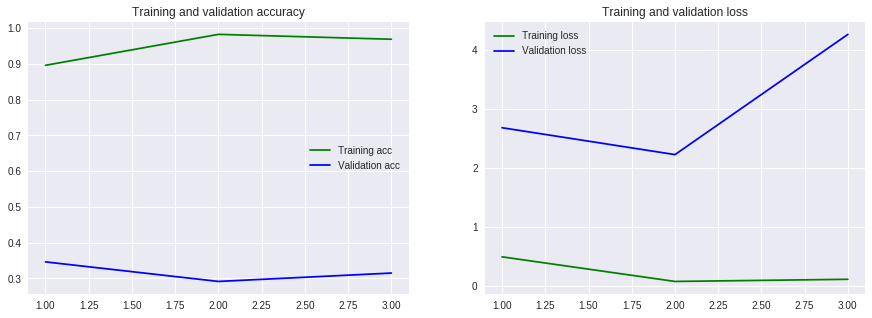

In [56]:
#plot training and validation accuracy and loss
plot_acc_loss(acc, val_acc, loss, val_loss)

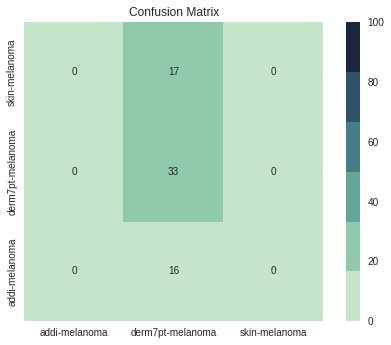

In [30]:
#plot confusion matrix
plot_confusion_matrix(confusion_matrix(actual, predicted), dataset_codename)

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/classification.py:1437: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples.
  'precision', 'predicted', average, warn_for)


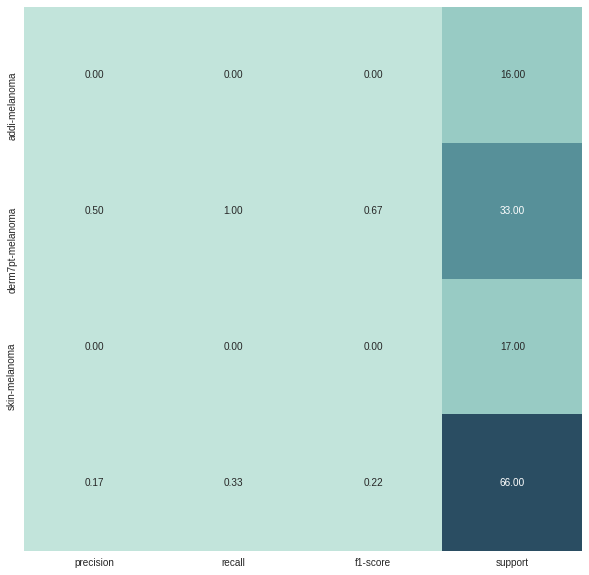

In [31]:
#plot classification report
plot_classification_report(actual, predicted, dataset_codename)

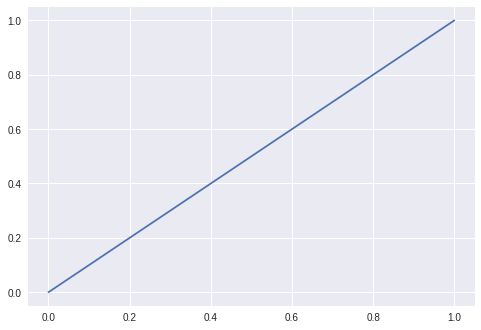

AUC: 0.5


In [58]:
#plot AUC ROC
auc_roc(actual, predicted)